In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import spacy

import tensorflow as tf

import keras
from keras.layers import Input, Dense, LSTM, Embedding, \
Dropout, Activation, Bidirectional, GlobalMaxPooling1D, GlobalAveragePooling1D
from keras.layers.experimental.preprocessing import TextVectorization
from keras.models import Sequential, load_model
from keras.optimizers import SGD
from keras.callbacks import ModelCheckpoint
from keras.initializers import Constant


# !pip install -q -U keras-tuner
# import kerastuner as kt

from wordcloud import WordCloud

from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression


from IPython.display import display

import re

import seaborn as sns
import matplotlib.pyplot as plt
from src import load_text, get_word_index, predict_grade, separate_sentences

# !python -m spacy download en_core_web_lg
import en_core_web_lg


pd.set_option('display.max_colwidth', None)
pd.set_option('display.max_rows',50)

# The Data
the data consists of anonymized essays and stories written by students in grades kindergarten through high school.  We've collected these from around the web.  Let's look at some statistics below.

## Alternative Grouping
We removed samples from grades K (0) and 1 because we suspect most of them were dictated and transcribed by teachers.  They don't seem to be representative of independent writing skills.

We also combined all high school grades to 12.  Previous iterations of the model did not do well distinguishing between high school level texts.  We changed them to 12 because later we want the model to use the average of sentences to predict the grade of a longer text.  The model almost never predict 12 because an average will always bring it down.

In [2]:
df = load_text(sentences=False, grammarize=False)
df = df[df['Grade'] > 1]
df.loc[df['Grade'] > 8, 'Grade'] = 12.0
sent_df = separate_sentences(df)

train = pd.DataFrame(columns=['Text','Grade'])
test = pd.DataFrame(columns=['Text','Grade'])

train['Text'], test['Text'], train['Grade'], test['Grade'] = \
                         train_test_split(df.Text, df.Grade, random_state=111)

sent_train = separate_sentences(train)
X_train = sent_train['Text']
y_train = sent_train['Grade']
X_t, X_val, y_t, y_val = train_test_split(X_train, y_train, random_state=111)

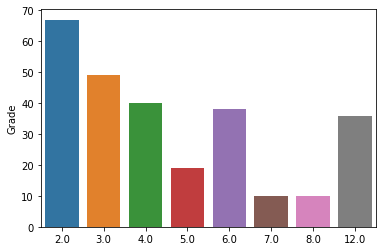

In [4]:
sns.barplot(x=df.Grade.unique(),y=df.Grade.value_counts())

You can see above that we have a large imbalance in grades represented.  It's tempting to cluster grades together, but we want a tool that predicts with some specificity.  Here's a lesson from my teaching years, however:  Most kids don't write sentences on their own in Kindergarten.  Looking over our texts for Kindergarten and first grade, these seem to be dictated and transcribed by an adult.  

In model development we also saw that high school texts are difficult to classify accurately as well.  For these reasons, we clump all high school and K-2nd grade together.  

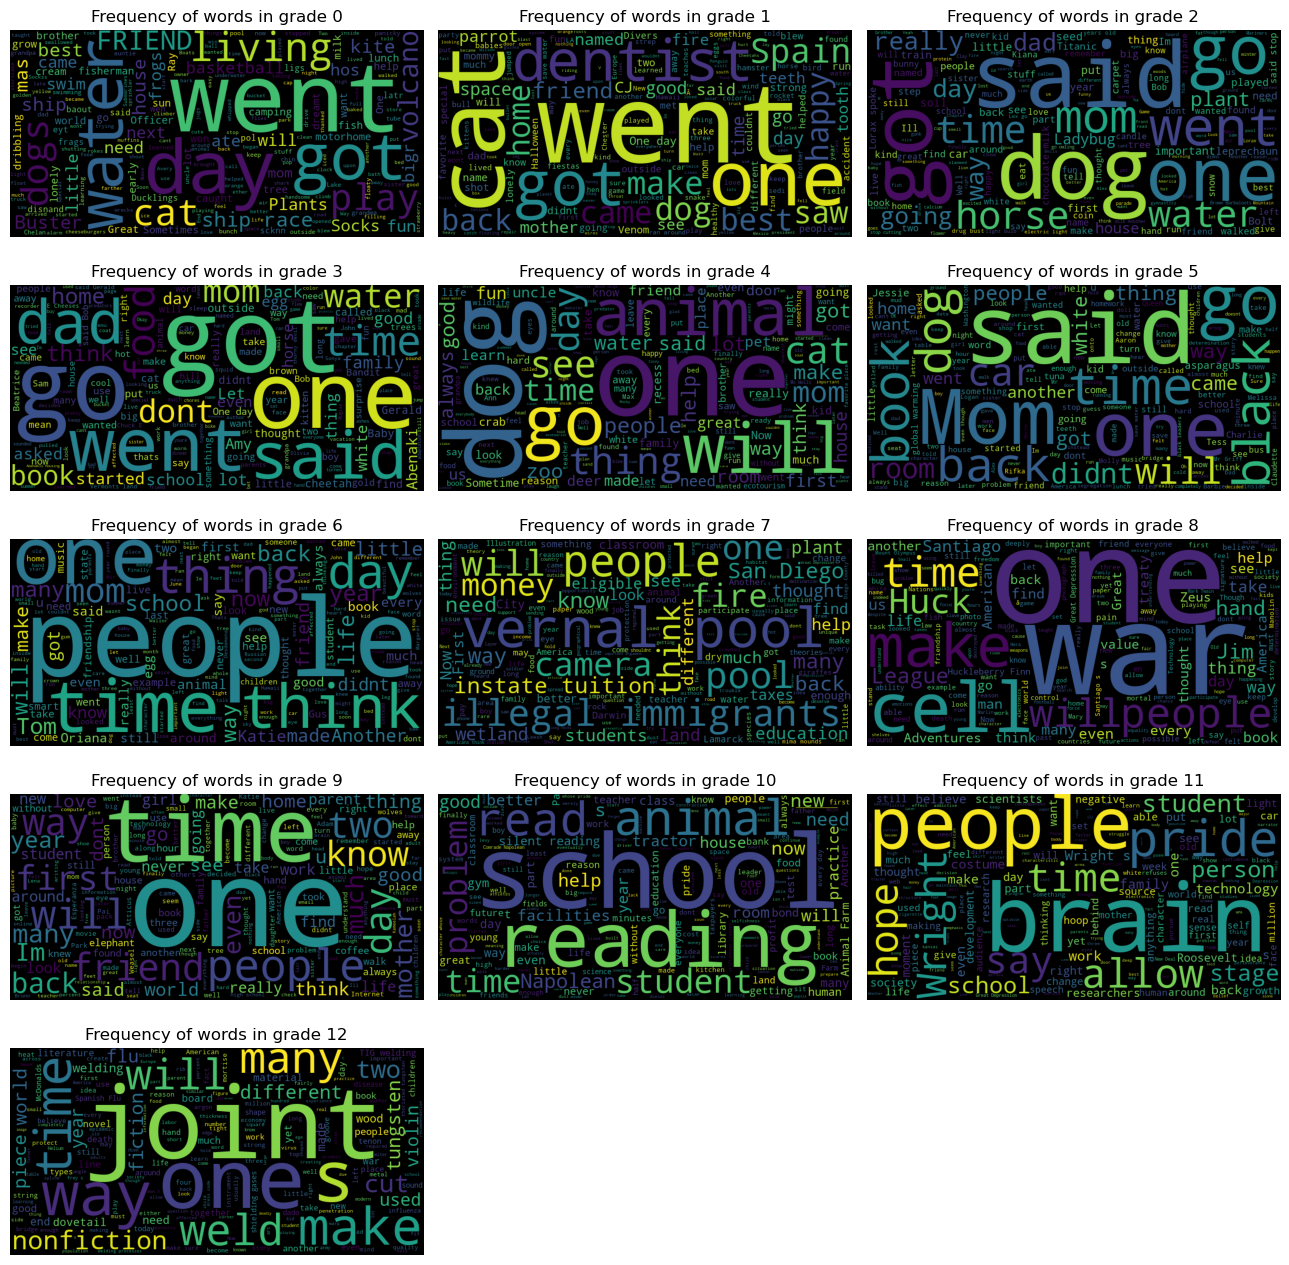

In [6]:
fig, axes = plt.subplots(5,3, figsize = (13,13))
axes=axes.ravel()
grades = sorted(df.Grade.unique())
for i, grade in enumerate(grades):
    text = ' '.join([story for story in df.loc[df.Grade == grade, 'Text']])
    axes[i].imshow(WordCloud(width=800, height=400).generate(text))
    axes[i].set_title(f'Frequency of words in grade {int(grade)}')
    axes[i].axis('off')
fig.delaxes(axes[-1])
fig.delaxes(axes[-2])
plt.tight_layout()
plt.savefig('word_clouds.png', dpi=200)
plt.show()
    

# FSM
How accurate would we be if we just predict all samples will be the median grade of the training set?  This can be our baseline model.

In [7]:
FSM = np.array([y_t.median()] * len(y_val))
FSM_MAE = np.sum(np.abs(y_val - FSM))/len(y_val)
print('Baseline MAE is: ', FSM_MAE)

Baseline MAE is:  2.645473041709054


So, that means our model has to beat 2.6 MAE to have any predictive power.

# TF-IDF Vectorization

TF-IDF vectorization represents each word with a float representing its relative specificity to a given document.  The random forest model, however, is non-sequential.  It looks at each sentence as a collection of words.  Therefor the above power represents the opportunity to judge writing level purely by vocabulary used.

I'd like to have longer input sequences after vectorizing and padding than my longest sentence.  But, the lower you set `max_tokens` the fewer resources your model will need.

In [8]:
Vectorizer = TextVectorization(output_mode='tf-idf', max_tokens=X_t.str.len().max())
Vectorizer.adapt(X_t.to_numpy())
X_t_tfidf = Vectorizer(X_t)
X_val_tfidf = Vectorizer(X_val)

# Linear Regression

Let's see how far we can get with the simplest of linear predictive models based on the vocabulary in the text.

In [9]:
lr_reg = LinearRegression().fit(X_t_tfidf, y_t)
yhat = lr_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('MAE for Linear Regression on TF-IDF vectors = ', mae)
print('Baseline MAE is: ', FSM_MAE)

MAE for Linear Regression on TF-IDF vectors =  2.292763477181855
Baseline MAE is:  2.645473041709054


The linear regression slightly beat predicting the median, but not by a lot.

# Random Forest Regressor

This is another traditional predictive model that averages the predictions of many decision tree models.  These models are not linear in their predictions like the linear regression model.  They often perform well on less linear datasets, but they take awhile to train.

In [10]:
RF_reg = RandomForestRegressor().fit(X_t_tfidf, y_t)
yhat = RF_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('MAE for Random forest TF-IDF vectors = ', mae)
print('Baseline MAE is: ', FSM_MAE)

MAE for Random forest TF-IDF vectors =  2.276116885860407
Baseline MAE is:  2.645473041709054


The random forest model also did not beat the baseline by very much.


# XGBoost

In [11]:
from xgboost import XGBRegressor
XGB_reg = XGBRegressor().fit(X_t_tfidf, y_t)
yhat = XGB_reg.predict(X_val_tfidf)
mae = np.sum(np.abs(y_val - yhat))/len(y_val)
print('MAE for XGBoost TF-IDF vectors = ', mae)
print('Baseline MAE is: ', FSM_MAE)

[10:43:42] WARNING: C:/Jenkins/workspace/xgboost-win64_release_0.90/src/objective/regression_obj.cu:152: reg:linear is now deprecated in favor of reg:squarederror.
MAE for XGBoost TF-IDF vectors =  2.3311995809342587
Baseline MAE is:  2.645473041709054


XGBoost did not seem to improve much.


## Model development opportunities:
My goal in this project is to explore deep learning NLP approaches, so I did not spend a lot of time tuning the traditional models.  I include them more as reference and justification for models that require greater computational resources.

Opportunities:

1. Hyperparameter tuning of traditional models

# Deep Models

I wonder if a model that explores the grammar and semantic relationships between words within the student writing samples might have greater insight into stages of writing development?  



# TextVectorization

We used TextVectorization as TF-IDF encoder above, but it can also be used as a Keras model layer.  I create a new TextVectorization object with appropriate sequence lengths for padding.  Each word will be encoded as an integer and sentences will be arrays of integers.

# Word Embedding

My first choice, in order to preserve some of the semantic relationships between the words I used word embeddings, rather than TF-IDF, to vectorize my texts.  This is a very different approach and, in fact, whereas in many other vectorization strategies each word is represented by a single number, word embeddings encode each word as a high dimensional vector array.  That means that a sentence becomes a 2D matrix.  

We don't encode the texts as such yet, but we do need to create a reference matrix to translate word encodings to their matching embedding vector.  Now Keras provides trainable embedding layers that learn along with the other layers of your model.  They contain huge numbers of weights depending on the size of your vocabulary and embedding length.

However, there are several libraries of pre-trained word embeddings that can be loaded.  I use the SpaCy NLP package to create a word embedding matrix as a 2D matrix.  The indices will be the keys and the matching row will be the embedding.  These integers match the encoding that the TextVectorization layer uses.

This matrix can then be loaded in as the weights of a Keras Embedding layer.  Remember to set `trainable=False`. The model will use the Embedding layer to cross-reference each word in the sentence.  These embeddings will suggest word relationships and will be read in order by the next layer, the Long-Short Term Memory layer.

Thanks to https://keras.io/examples/nlp/pretrained_word_embeddings/ and Kefei Mo https://towardsdatascience.com/hands-on-nlp-deep-learning-model-preparation-in-tensorflow-2-x-2e8c9f3c7633 for the below code to create the weights matrix:

In [12]:
# Establish sequence length.  Set here as the longest sentence in the training set.
longest_sentence = X_train.str.len().max()

# Instantiate and fit the vectorizing layer.  
# We can use this as a transformer, a vocabulary, and a layer in our model.
Vectorizer = TextVectorization(output_sequence_length=longest_sentence, max_tokens=2000)
Vectorizer.adapt(X_train.to_numpy())
vocab = Vectorizer.get_vocabulary()

# Load the SpaCy model as 'nlp'
nlp = en_core_web_lg.load()

#generate the embedding matrix
num_tokens = len(vocab)
embedding_dim = len(nlp('The').vector)
embedding_matrix = np.zeros((num_tokens, embedding_dim))
for i, word in enumerate(vocab):
    embedding_matrix[i] = nlp(word).vector

#Load the embedding matrix as the weights matrix for the embedding layer and set trainable to False
Embedding_layer=Embedding(
    num_tokens,
    embedding_dim,
    embeddings_initializer=Constant(embedding_matrix),
    trainable=False)

# Hybrid Bi-directional
We are going to pull out all the guns here and use a bi-directional LSTM with that pre-trained SpaCy embedding layer.  We are going to throw that on top of a deep densely connected network with a global max pool layer between them.

The data comes in at the input layer and to the vectorizing layer which translates them into uniform length integer arrays.  Those arrays are are expanded into a 2D matrix in the Embedding layer.  The LSTM layer then reads the embeddings in the order they originally appeared in the text and makes choices about them.  This is a learned skill.  The bidirectional wrapper sends the text embedding both forward and backward through the layer and concatenates the output sequences together.  The GlobalMaxPooling1D layer reduces the dimensionality back down to pass to the densely connected layers.

The model then outputs a float which represents its guess at the grade level of the author of a text.

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
text_vectorization_1 (TextVe (None, 364)               0         
_________________________________________________________________
embedding (Embedding)        (None, 364, 300)          600000    
_________________________________________________________________
bidirectional (Bidirectional (None, 364, 200)          320800    
_________________________________________________________________
global_max_pooling1d (Global (None, 200)               0         
_________________________________________________________________
dropout (Dropout)            (None, 200)               0         
_________________________________________________________________
dense (Dense)                (None, 128)               25728     
_________________________________________________________________
dropout_1 (Dropout)          (None, 128)               0

Epoch 14/60
629/629 [==============================] - ETA: 0s - loss: 1.7252
Epoch 00014: val_loss did not improve from 1.89805
629/629 [==============================] - 434s 691ms/step - loss: 1.7252 - val_loss: 1.9094
Epoch 15/60
629/629 [==============================] - ETA: 0s - loss: 1.6982
Epoch 00015: val_loss did not improve from 1.89805
629/629 [==============================] - 443s 705ms/step - loss: 1.6982 - val_loss: 1.9443
Epoch 16/60
629/629 [==============================] - ETA: 0s - loss: 1.6379
Epoch 00016: val_loss did not improve from 1.89805
629/629 [==============================] - 436s 694ms/step - loss: 1.6379 - val_loss: 1.9063
Epoch 17/60
629/629 [==============================] - ETA: 0s - loss: 1.6013
Epoch 00017: val_loss improved from 1.89805 to 1.87824, saving model to model-BiLSTM-MLP-hybrid
INFO:tensorflow:Assets written to: model-BiLSTM-MLP-hybrid\assets
629/629 [==============================] - 471s 748ms/step - loss: 1.6013 - val_loss: 1.8782
E

Epoch 49/60
629/629 [==============================] - ETA: 0s - loss: 1.1001
Epoch 00049: val_loss did not improve from 1.76965
629/629 [==============================] - 421s 669ms/step - loss: 1.1001 - val_loss: 1.8043
Epoch 50/60
629/629 [==============================] - ETA: 0s - loss: 1.1081
Epoch 00050: val_loss did not improve from 1.76965
629/629 [==============================] - 419s 667ms/step - loss: 1.1081 - val_loss: 1.8177
Epoch 51/60
629/629 [==============================] - ETA: 0s - loss: 1.0813
Epoch 00051: val_loss did not improve from 1.76965
629/629 [==============================] - 419s 667ms/step - loss: 1.0813 - val_loss: 1.7887
Epoch 52/60
629/629 [==============================] - ETA: 0s - loss: 1.0968
Epoch 00052: val_loss did not improve from 1.76965
629/629 [==============================] - 416s 661ms/step - loss: 1.0968 - val_loss: 1.7984
Epoch 53/60
629/629 [==============================] - ETA: 0s - loss: 1.0860
Epoch 00053: val_loss did not impr

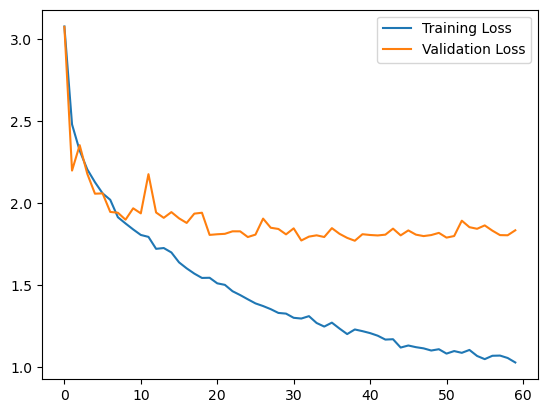

In [13]:
from keras.layers import GlobalMaxPooling1D

filepath = 'model-BiLSTM-MLP-hybrid'
def make_BiLSTM():
    model = Sequential()
    model.add(Input(shape=(1,), dtype=tf.string))
    model.add(Vectorizer)
    model.add(Embedding_layer)
    model.add(Bidirectional(LSTM(100, return_sequences=True)))
    model.add(GlobalMaxPooling1D())
    model.add(Dropout(rate=0.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(128, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(64, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(32, activation='relu'))
    model.add(Dropout(rate=.2))
    model.add(Dense(1, activation='relu'))
    model.compile(optimizer='adam', loss='mean_absolute_error')
    return model

model = make_BiLSTM()
print(model.summary())
checkpoint = ModelCheckpoint(filepath, monitor='val_loss', verbose=1, 
                             save_best_only=True,
                             mode='min',
                             save_format='tf'
                             )
callbacks = [checkpoint]

history = model.fit(X_train,
            y_train,
            epochs=60,
            batch_size=10,
            validation_split = .2,
            verbose=1,
            callbacks=callbacks)

plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.legend()
plt.show()

# Model Evaluation
This model takes forever to train.  While having a frozen embedding layer helps reduce the number of weights to update, you'll want to train this on something with a good CUDA GPU.  It scores a 1.7 grade level average error, quite a bit better than the FSM accuracy of 2.5.  

In [21]:
filepath = 'model-BiLSTM-MLP-hybrid'
model = keras.models.load_model(filepath)
yhat = model.predict(X_test).ravel()
print('MAE = ', np.sum(np.abs(y_test-yhat))/len(y_test))
print('STD of errors: ', np.abs(y_test - yhat).std())
print('mean grade prediction = ', np.mean(yhat))
print('mean grade = ', np.mean(y_test))

errors = pd.DataFrame()
errors['Text'] = X_test
errors['Grade'] = y_test
errors['Predicted Grade'] = yhat
errors.sample(5)

MAE =  1.8149366129635855
STD of errors:  1.737088326037774
mean grade prediction =  7.060441
mean grade =  6.948893974065599


,Text,Grade,Predicted Grade
2573,From now on I will be more cautious when I ride my bike,3.0,7.621160
418,Sometimes my sisters would come swimming too,4.0,3.843397
1068,Travel to the redstone house,6.0,6.051738
7631,It made me wake up to the real world and learn that everyone is affected by war both those who are killed and injured and those who kill and injure them,8.0,6.439133
7374,said Molly,5.0,3.200037


# Sentence Average Grade Approach

In order to create more data to train on we split samples into individual sentences while retaining the original grade label for each one.  New texts then will also be broken down into sentences, individual predictions are made on each sentence, and the model returns the mean average grade level prediction over all sentences. 

This approach was to combat previous bias in our models toward longer texts being higher grades, to create more data, and to reduce the size of input sequences.  Some of the texts are several pages long.  This also somewhat helped the class imbalance because the older students, which we had fewer of, also wrote texts with more sentences.  

Finally, it can take advantage of the 'Wisdom of the Crowds' effect to improve the accuracy on longer texts.

`predict_grade()` splits the input text into sentences, uses the input model to make predictions on each one, then returns the mean average of the sentences level predictions as the prediction for the entire text.

In [30]:
model = load_model('model-BiLSTM-MLP-hybrid')
errors = test.copy().reset_index(drop=True)
yhat = predict_grade(model, test.Text)
errors['average_prediction'] = yhat

print('MAE of average sentence predictor is: ', np.sum(np.abs(errors['Grade'] - errors['average_prediction']))/len(errors))
errors.sample(5)

MAE of average sentence predictor is:  1.4587132253764588


,index,Text,Grade,average_prediction
51,310,"Civil disobedience is the refusal to follow an unjust law. Gandhi led India to independence by using civil disobedience and non-violent resistance. His motto was, “will not fight, will not comply.” One of Gandhi’s first acts of civil disobedience was when he refused to move to 3rd class on the train. He bought a 1st class ticket but they wouldn’t let him sit there. He then got kicked off the train. This is just one example of Gandhi’s enforcement of non-violent resistance. He has done many things from refusing to get off the sidewalk to being beaten for burning his pass. He figured that if he died, it would be for the right reasons. He said, “They can have my body, not my obedience.” Eventually he got all of India going against Britain’s unjust laws. While it took the people of India longer to realize, Gandhi proved that civil disobedience and non-violent resistance can be a more effective way of fighting back. Britain finally let India have its independence.",9.0,7.517720
22,143,As I step out of the pick-up it hits me the smell of manure drifting down from the barn. A sliding glass door swishes open and clomping down the ramp is my boss Robert Taylor. Put your lunch in the van Steve. Ill be there in a minute. I turn and walk toward the van an old 69 green and white Dodge Sportsman covered with an inch of dust. When I open the door and peer in it reminds me of a walk-in trash can. The floor lies out of sight underneath a sea of garbage. I kick some garbage out of my way and hop up in the seat. Before long here comes Rob clomping across the driveway. He opens the door groans as he gets up into his seat cranks the motor over and the motor sputters to a start filling the air inside the van with the smell of burnt oil. My first impression is that we wont make it out of the driveway but we sputter out onto the road and head toward town. When we pull into the circular drive I peer through the dust-smudged window to find that the tractor is still there. On the side it reads Massey-Ferguson but with Robert its hard telling what it really is. As I sit down in the seat I adjust the hunk of foam rubber to a comfortable position. Once I have accomplished this I sit down and start cranking on the prehistoric starter. Slowly and then more rapidly like a steam engine building up speed the black smoke rolls out of the pipe functioning as a muffler and away we go.,9.0,8.373815
57,109,I tried to run but I couldnt. The monster seemed like it was growing by the minute! And then the most horrible thing was about to happenâ€¦ I screamed and sat bolt upright up in bed. I gasped swallowing huge amounts of air. Id just had the most horrible nightmare ever. Id never been so scared in my life! Still gasping I called Mom! My mom came sleepily into my bedroom and sat on the edge of my bed. What is it sweetie? she asked her voice full of concern. Tears swelled up in my eyes as I remembered the ghostly monster from my dream. Iâ€¦ I had a nightmare. I finally managed to say. Poor thing my Mom said sympathetically as she gave me a hug. But dont worry she said you will stop having them when you grow up. I nodded my head in agreement. Although inside I secretly felt that I wouldnt. After my Mom left I lay on my pillows and started to think. Peopleâ€”mostly grownupsâ€”were always telling me that things would happen or I would like something better when I was grown up. Apparently they thought being grown up meant liking everything and knowing everything. Well I most certainly did not! Personally I thought growing up meant having responsibility and trying to make good choices etc. I wondered if my life would be different as a grown-up. I mean I knew I would be older and more mature but would I be prettier? fatter? skinnier? would I choose to get married? or get a job? Then I realized something. I was nine years of age. Right now none of that stuff mattered. I didnt need a husband because I had older siblings! I didnt ne

The accuracy jumped from 1.8 grade levels average error to 1.4.  In other words, the longer the writing sample, the more accurate the model should be, at least up to a point.

Another note here is that while the model takes a long time to load, being almost a 1GB in size, the predictions aren't too slow.

# Conclusion
With a top accuracy of 1.4 grade levels average error, this model is probably not very useful to a teacher.  It could be fun to play around with, or to dig into to try to assess what it's using to make its predictions.  

However, it needs more data to train on.  There are many aspects that go into writing development and the small sample size of our data doesn't give enough.  While dividing texts by sentences raises our sample size from ~300 to ~10,000, there are still only 300 individual writers represented.  The component sentences in a document are going to be highly correlated and therefor offer less diverse information to the model than if all 10,000 were from independent sources.

# Future Study
I recommend more study go into modeling writing development.  A greater emphasis will need to be put on quality, diverse, and plentiful samples.  

There are also many more opportunities for text preparation.  NLP is a complex art and tools abound.